# Laboratorium

### Konfiguracja

In [91]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [92]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
        ### Kod kradziony przyznaję się bez bicia
    def save(self, scene_index, path='.'):
        plt.close()
        ax = plt.axes()
        plt.axis('square')
        scene = self.scenes[scene_index]
        for collection in scene.points:
            if len(collection.points) > 0:
                ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (scene.lines):
            ax.add_collection(collection.get_collection())
        ax.autoscale(True)
        plt.savefig(path+"/figure_"+str(scene_index)+".png")
        

# Rozwiązanie

In [93]:
%matplotlib notebook

In [146]:
import functools
import sortedcontainers
import copy as cp
from math import sqrt
from queue import PriorityQueue
from random import *
import time

### Funkcje matematyczne

In [95]:
#funkcja znajdująca punkt na okręgu przechodzącym przez punkty p0,p1,p2 o najmniejszej współżędnej y
def circle_minimum(p0,p1,p2):
        k=2*(p1[0]-p0[0])
        l=2*(p1[1]-p0[1])
        m= p0[0]*p0[0] - p1[0]*p1[0] + p0[1]*p0[1] - p1[1]*p1[1] 
        p=2*(p2[0]-p0[0])
        q=2*(p2[1]-p0[1])
        r=p0[0]*p0[0] - p2[0]*p2[0] + p0[1]*p0[1] - p2[1]*p2[1]
        
        a = (r*l-m*q)/(k*q-p*l)
        b = (r*k-m*p)/(p*l-k*q)
        r = sqrt((p0[0]-a)**2 + (p0[1]-b)**2)
        return b-r

In [96]:
#Funkcja znajdująca wektor prostopadły do odcinka (pl,pr) skierowany lewo
def get_vector(pl,pr):
    return (pl[1]-pr[1],pr[0]-pl[0])

In [97]:
#funckja ustalająca położenie punktu c względem odcinka ab z użyciem wyznacznika
def side_of_c(a,b,c): 
    tab = np.array([[a[0]-c[0], a[1]-c[1]],[b[0]-c[0], b[1]-c[1]]])
    d = np.linalg.det(tab)
    if d > 0:
        return -1 # c po lewej od ab
    elif d == 0:
        return 0 # c na ab
    else: 
        return 1 # c po prawej od ab


In [98]:
#znajdowanie ograniczeń do wizualizacji

#funkcja znajdująca punkt przecięcia odcinka zadanego przez 
#wektor oraz punkt z
#prostą zadanej współżędnej y
def get_y_intersect(y,vector,point):
    x = (y-point[1])*vector[0]/vector[1]+point[0]
    return x,y

#funkcja znajdująca punkt przecięcia odcinka zadanego przez 
#wektor oraz punkt z
#prostą zadanej współżędnej x
def get_x_intersect(x,vector,point):
    y = (x-point[0])*vector[1]/vector[0]+point[1]
    return x,y


#funkcja znajdująca punkt przecięcia odcinka zadanego przez 
#wektor oraz punkt z
#prostokątem o zadanych współżędnych równoległych do osi układu w R^2
def find_end_box(point,vector,margin):
    l,r,d,u = margin
    if vector[0] == 0:
        if vector[1] > 0:
            return (point[0],u)
        else:
            return (point[0],d)
        
    elif vector[1] == 0:
        if vector[0] > 0:
            return (r,point[1])
        else:
            return (l,point[1])
    
    if vector[0] > 0 and vector[1] > 0:
        x,y = get_x_intersect(r,vector,point)
        if y > u:
            x,y = get_y_intersect(u,vector,point)
    elif vector[0] < 0 and vector[1] < 0:
        x,y = get_x_intersect(l,vector,point)
        if y < d:
            x,y = get_y_intersect(d,vector,point)
    elif vector[0] < 0 and vector[1] > 0:
        x,y = get_x_intersect(l,vector,point)
        if y > u:
            x,y = get_y_intersect(u,vector,point)
    else:
        x,y = get_x_intersect(r,vector,point)
        if y < d:
            x,y = get_y_intersect(d,vector,point)
    return (x,y)

In [99]:
#klasa przedstawiająca odcinki szukanego podziału
class edge:
    
    #punkty po lewej takie, że odcinek jest symetralną odcinka powstałego przez ich połączenie
    pointL = None
    pointR = None
    
    #początek i koniec odcinka
    start = None
    end = None
    
    #odcinek skierowany w przeciwną stronę(ma odwrotne punktey pointL,pointR oraz start,end)
    opposite = None
    
    
    def __init__(self,pointL,pointR):
        self.pointL = pointL
        self.pointR = pointR
        

In [100]:
#klasa przedstawiająca łuk paraboli
class arc:
    # punkt będący ogniskiem paraboli
    point = None
    
    #czy zdażenie okręgowe w którym łuk bierze udział może zajść
    active = True
    
    #czy zdażenie okręgowe w którym łuk znika może zajść
    circle_event_active = True
    
    
    def __init__(self,point):
        self.point = point

In [101]:
#klasa przechowująca łuki i odcinki w drzewie bst
class bst_node:
    #przechowywany łuk
    arc = None
    
    #przechowywany odcinek
    edge = None
    
    #prawe i lewe dziecko oraz rodzic w drzewie
    right = None
    left = None
    parent = None
    
    
    def __init__(self,parent = None):
        parent = parent

### Drzewo BST

In [102]:
class bst_tree:
    #aktualna pozycja miotły
    l = None
    
    #'korzeń' drzewa
    root = None
    
    
    
    
    
    
    def __init__(self,l):
        self.l = l
        self.root = None
    
    
    
    
    
    
    #funkcja aktualizująca pozycję miotły
    def update_l(self,l):
        self.l = l
    
    
    
    
    
    
    #funkcja wypisująca wsystkie parabole miotły według kolejności
    def print_tree(self):
        print("startPrinting")
        node = self.root
        while node.left != None:
            node = node.left
        while node != None:
            print(node.arc.point)
            node = self.next_leaf(node)
        print("stopPrinting")
    
    
    
    
    
    
    #funkcja znajdująca przecięcia parabol o ogniskach w danych punktach w aktualnej pozycji miotły
    def get_arch_intersect(self,pl,pr):
        l = self.l
        
        # przypadek gdy y1 == y2
        if pr[1]==pl[1]:
            if pl[1] == l:
                return ((pr[0]+pl[0])/2,pl[1])
            x0,y0=pl[0],pl[1]
            a0 = 1/(2*(y0-l))
            b0 = -1*x0/(y0-l)
            c0 = (x0*x0 + y0*y0 - l*l)/(2*(y0-l))
            x = (pr[0]+pl[0])/2
            return (x,a0*x**2+b0*x+c0)
        
        #przypadek gdy któryś z łuków leży na prostej miotły
        if pl[1] == l:
            x1,y1=pr[0],pr[1]
            a1 = 1/(2*(y1-l))
            b1 = -1*x1/(y1-l)
            c1 = (x1*x1 + y1*y1 - l*l)/(2*(y1-l))
            x = pl[0]
            return (x,a1*x**2+b1*x+c1)
        if pr[1] == l:
            x0,y0=pl[0],pl[1]
            a0 = 1/(2*(y0-l))
            b0 = -1*x0/(y0-l)
            c0 = (x0*x0 + y0*y0 - l*l)/(2*(y0-l))
            x = pr[0]
            return (x,a0*x**2+b0*x+c0)
        
        #przypadek domyślny
        x0,y0=pl[0],pl[1]
        a0 = 1/(2*(y0-l))
        b0 = -1*x0/(y0-l)
        c0 = (x0*x0 + y0*y0 - l*l)/(2*(y0-l))
        x1,y1=pr[0],pr[1]
        a1 = 1/(2*(y1-l))
        b1 = -1*x1/(y1-l)
        c1 = (x1*x1 + y1*y1 - l*l)/(2*(y1-l))
        a = a1-a0
        b = b1-b0
        c = c1-c0
        x = (-b-sqrt(b*b-4*a*c))/(2*a)
        y = a0*x**2+b0*x+c0
        return (x,y)
        
        

        
        
        
    #funkcja znajdująca łuk paraboli znajdujący się na miotle nad punktem jej punktem o zadanej współżędnej x
    def find(self,x):
        if self.root == None:
            return None
        current_node = self.root
        
        #binary search
        while current_node.arc == None:
            if x > self.get_arch_intersect(current_node.edge.pointL,current_node.edge.pointR)[0]:
                current_node = current_node.right
            else:
                current_node = current_node.left
        return current_node
        
    
    
    
    
    
    #znajdowanie najbliższego prawego rodzica zadanego liścia
    def get_right_parent(self,node):
        if node.parent == None:
            return None
        result = node
        while result.parent.right == result:
            result = result.parent
            if result.parent == None:
                return None
        result = result.parent
        return result
    
    #znajdowanie najbliższego prawego liścia zadanego 
    def get_right_child(self,node):
        result = node.right
        while result.left is not None:
            result = result.left
        return result
    
    #znajdowanie najbliższego lewego rodzica zadanego liścia
    def get_left_parent(self,node):
        if node.parent == None:
            return None
        result = node
        while result.parent.left == result:
            result = result.parent
            if result.parent == None:
                return None
        result = result.parent
        return result
    
    #znajdowanie najbliższego lewego liścia zadanego 
    def get_left_child(self,node):
        result = node.left
        while result.right is not None:
            result = result.right
        return result
    
    #znajdowanie najbliższego prawego liścia dla zadanego liścia
    def prev_leaf(self,node):
        prev_edge = self.get_left_parent(node)
        if prev_edge is not None:
            return self.get_left_child(prev_edge)
        else:
            return None
    
    #znajdowanie najbliższego lewego liścia dla zadanego liścia
    def next_leaf(self,node):
        next_edge = self.get_right_parent(node)
        if next_edge is not None:
            return self.get_right_child(next_edge)
        else:
            return None
    
    
        
        
        
        
        
    #funkcja dodawania elementu do drzewa, która jednocześnie obsługuje zdażenie punktowe
    def insert(self,p):
        #przypadek gdy drzewo jest puste
        if self.root is None:
            self.root = bst_node()
            self.root.arc = arc(p)
            return
        
        #znajdowanie łuku nad zadanym punktem
        node = self.find(x=p[0])
        
        #usuwanie zdażenia okręgowego dla dzielonego uku łuku
        node.arc.circle_event_active = False
        
        
        
        #Zamienienie liścia paraboli na odpowiednie poddrzewo przedstawiające nowo wstawioną parabolę
        #Nowa paraba, jej nowi sąsiedzi powstali przez podział paraboli oraz odcinki między nimi 
        
        #łuk polewej ma ognisko tam gdzie usuwany łuk
        nodeArcLeft = bst_node()
        nodeArcLeft.arc = arc(node.arc.point)
        
        #łuk po prawej ma ognisko tam gdzie usuwany łuj
        nodeArcRight = bst_node()
        nodeArcRight.arc = arc(node.arc.point)
        
        #odcinek pomiędzy lewym łukiem a nowo powstałym 
        nodeEdgeLeft = bst_node() 
        nodeEdgeLeft.edge = edge(node.arc.point,p)
        
        #odcinek pomiędzy prawym łukiem a nowo powstałym
        nodeEdgeRight = bst_node()
        nodeEdgeRight.edge = edge(p,node.arc.point)
        
        #łączenie odcinków jako przeciwne w celu poprawnej aktualizacji ich końców przy zdażeniach okręgowych
        nodeEdgeLeft.edge.opposite, nodeEdgeRight.edge.opposite = nodeEdgeRight.edge, nodeEdgeLeft.edge
        
        #tworzenie nowego łuku
        newNode = bst_node()
        newNode.arc = arc(p)
        
        #'składanie' poddrzewa
        nodeEdgeLeft.left = nodeArcLeft
        nodeArcLeft.parent = nodeEdgeLeft
        nodeEdgeLeft.right = nodeEdgeRight
        nodeEdgeRight.parent = nodeEdgeLeft
        nodeEdgeRight.left = newNode
        newNode.parent = nodeEdgeRight
        nodeEdgeRight.right = nodeArcRight
        nodeArcRight.parent = nodeEdgeRight
        
        #przepinanie wskaźników i usuwanie starego łuku
        parent = node.parent
        if parent == None:
            self.root = nodeEdgeLeft
        elif parent.left == node:
            parent.left = nodeEdgeLeft
        else:
            parent.right = nodeEdgeLeft
        nodeEdgeLeft.parent = parent
        node.parent = None
        
        
        
        #sprawdzanie czy występuje nowe zdażenie okręgowe
        
        #czy istnieje łuk odpowiednio na prawo od prawego łuku i na lewo od lewego łuku
        secondLeft = self.prev_leaf(nodeArcLeft)
        secondRight = self.next_leaf(nodeArcRight)
        
        #zdażenie okręgowe nie występuje gdy:
        #nie istnieje trzeci łuk 
        if secondLeft == None:
            leftSet = None   
        #licząc od lewej do prawej łuki nie idą zgodnie ze wskazówkami zegara
        elif side_of_c(secondLeft.arc.point,nodeArcLeft.arc.point,newNode.arc.point) != 1: 
            leftSet = None
        #współżędna y najniższego punktu okręgu znajduje się już nad miotłą
        elif circle_minimum(secondLeft.arc.point,nodeArcLeft.arc.point,newNode.arc.point) > self.l:
            leftSet = None
        else:
            leftSet = [secondLeft.arc,nodeArcLeft,newNode.arc]
        #(identyczne warunki dla prawej strony)
        if secondRight == None:
            rightSet = None
        elif side_of_c(newNode.arc.point,nodeArcRight.arc.point,secondRight.arc.point) != 1:
            rightSet = None
        elif circle_minimum(newNode.arc.point,nodeArcRight.arc.point, secondRight.arc.point,) > self.l:
            rightSet = None
        else:
            rightSet = [newNode.arc,nodeArcRight,secondRight.arc]
        
        
        
        #zwracamy 2 zbiory potencjalnych zdażeń okręgowych oraz lewy i prawy odcinek do wstawienia do zbioru wynikowego
        return leftSet, rightSet, nodeEdgeLeft.edge, nodeEdgeRight.edge
        
    
    
    
    
    
    
    #funkcja usuwania elementu z drzewa, która jednocześnie obsługuje zdażenie okręgowe
    def delete(self, node):
        
        #ustalanie odcinków których punkt wspólny przetwarzamy
        leftEdgeNode = self.get_left_parent(node)
        rightEdgeNode = self.get_right_parent(node)
        
        #ustalenie łuków które od teraz będą sięprzecinały
        leftArcNode = self.get_left_child(leftEdgeNode)
        rightArcNode = self.get_right_child(rightEdgeNode)
        
        #ustalenie punktu przecięcia
        intersect_point = self.get_arch_intersect(leftArcNode.arc.point,rightArcNode.arc.point)
        
        #aktualizacja końcówek odcinków
        rightEdgeNode.edge.start = intersect_point
        rightEdgeNode.edge.opposite.end = intersect_point
        leftEdgeNode.edge.start = intersect_point
        leftEdgeNode.edge.opposite.end = intersect_point
        
        #tworzenie nowego odcinka i odcinka do niego przeciwnego
        newEdge = edge(leftArcNode.arc.point,rightArcNode.arc.point)
        oppositeEdge = edge(rightArcNode.arc.point,leftArcNode.arc.point)
        newEdge.opposite,oppositeEdge.opposite = oppositeEdge,newEdge
        newEdge.end = intersect_point
        oppositeEdge.start = intersect_point
        
        #dezaktywacja usuwanego łuku
        node.arc.active = False
        
        #usunięcie łuku i jego rodzica(jednego z sąsiadów-odcinków)
        #zamienienie odcinka(obiektu edge) na nowy odcinek(obiekt edge) w węźle dotychczas przechowującym drugiego sąsiada-odcinka 
        parent = node.parent
        grandparent = parent.parent
        if parent == rightEdgeNode:
            otherSubTree = parent.right
            otherParent = leftEdgeNode
        else:
            otherSubTree = parent.left
            otherParent = rightEdgeNode   
        if grandparent.left == parent:
            grandparent.left = otherSubTree
        else:
            grandparent.right = otherSubTree
        otherSubTree.parent = grandparent
        otherParent.edge = newEdge
        
        #usunięcie łuku i dezaktywacja zdażeń okręgowych zawierających go
        parent.parent = None
        parent.left,parent.right,parent.edge = None,None,None
        node.arc.active = False
        node.parent = None
        
        
        
        #sprawdzanie czy występuje nowe zdażenie okręgowe
        
        #czy istnieje łuk odpowiednio na prawo od prawego łuku i na lewo od lewego łuku
        secondRight = self.next_leaf(rightArcNode)
        secondLeft = self.prev_leaf(leftArcNode)
                
        #warunki identyczne jak w poprzedniej części algorytmu
        if secondRight == None:
            rightSet = None
        elif side_of_c(leftArcNode.arc.point,rightArcNode.arc.point,secondRight.arc.point) != 1: 
            rightSet = None
        elif circle_minimum(leftArcNode.arc.point,rightArcNode.arc.point,secondRight.arc.point) > self.l:
            rightSet = None
        else:
            rightSet = [leftArcNode.arc,rightArcNode,secondRight.arc]
        if secondLeft == None:
            leftSet = None
        elif side_of_c(secondLeft.arc.point,leftArcNode.arc.point,rightArcNode.arc.point) != 1:
            leftSet=None
        elif circle_minimum(secondLeft.arc.point,leftArcNode.arc.point,rightArcNode.arc.point) > self.l:
            leftSet=None
        else:
            leftSet = [secondLeft.arc,leftArcNode,rightArcNode.arc]
        
        
        
        #zwracamy potencjalne zbiory dla zdażeń okręgowych i jeden wskaźnik na nowy odcinek
        return leftSet,rightSet,newEdge

### Algorytm Fortune'a

In [155]:
def fortune(points):
    n = len(points)
    if n < 2:
        return []
    
    
    
    #ograniczenia na współżędne punktów
    min_x, min_y, max_x, max_y = points[0][0], points[0][1], points[0][0], points[0][1]
    for p in points:
        if p[0] < min_x:
            min_x = p[0]
        if p[0] > max_x:
            max_x = p[0]
        if p[1] < min_y:
            min_y = p[1]
        if p[1] > max_y:
            max_y = p[1]
    
    
    #liczymy star czasu
    time_start = time.time()
    
    
    
    #pozycja miotły
    l = max_y
    
    
    
    # zbiór wynikowy krawędzi
    result = []
    
    
    
    #struktura stanu
    bst = bst_tree(l)
    
    
    
    #Struktura zdażeń - kolejka priorytetowa 
    #-p[1] odpowiada za kolejność zdażeń (od góry do dołu)
    #True oznacza, że zdażenie jest zdażeniem punktowym
    events = PriorityQueue()
    for p in points:
        events.put((-p[1],(True,p)))
    
    
    
    #przetwarzanie zdażenia punktowego
    #dodajemy odcinki do zbioru wynikowego i dodajemy zdażenia okręgowe do struktury zdażeń
    def handle_site_event(p):
        leftSet, rightSet, edgeLeft, edgeRight = bst.insert(p)
        result.append(edgeLeft)
        result.append(edgeRight)
        #appendować opposite?
        add_circle_event(leftSet)
        add_circle_event(rightSet)
        
    
    
    #przetwarzanie zdażenia okręgowego
    #dodajemy odcinek do zbioru wynikowego oraz zdażenia okręgowe do struktury zdażen
    def handle_circle_event(eventSet):
        if not (eventSet[0].active and eventSet[1].arc.active and eventSet[1].arc.circle_event_active and eventSet[2].active):
            return None
        leftSet,rightSet,newEdge = bst.delete(eventSet[1])
        result.append(newEdge)
        add_circle_event(leftSet)
        add_circle_event(rightSet)
    
    
    
    #dodanie zdażenia okręgowego jeśli nie jest None
    def add_circle_event(eventSet):
        if eventSet is None:
            return None
        node = eventSet[1]
        a,b,c = eventSet[0].point ,eventSet[1].arc.point, eventSet[2].point
        lowY = circle_minimum(a,b,c)
        events.put(   (-lowY,(False,eventSet))   )
        
    
    
    
    
    
    # pierwsze zdażenie obsługujemy ręcznie
    newl, (is_site_event, event_element) = events.get()
    l = -newl 
    p = event_element
    bst.insert(p)
    
    #działanie algorytmu w pętli
    while not events.empty():
        newl, (is_site_event, event_element) = events.get()
        l = -newl
        bst.update_l(l)
        if is_site_event:
            handle_site_event(event_element)
        else:
            handle_circle_event(event_element)
    
    
    
    #stop czasu
    time_end = time.time()
            
    
    
    
    
    #sprawdzenie czy punkty przecięcia nie wyszły poza dotychczasowy margines w celu poprawnej wizualizacji
    for edge in result:
        if edge.start != None:
            if edge.start[0] < min_x:
                min_x = edge.start[0]
            if edge.start[0] > max_x:
                max_x = edge.start[0]
            if edge.start[1] < min_y:
                min_y = edge.start[1]
            if edge.start[1] > max_y:
                max_y = edge.start[1]
        if edge.end != None:
            if edge.end[0] < min_x:
                min_x = edge.end[0]
            if edge.end[0] > max_x:
                max_x = edge.end[0]
            if edge.end[1] < min_y:
                min_y = edge.end[1]
            if edge.end[1] > max_y:
                max_y = edge.end[1]
          
    #ustalenie nowego marginesu
    width,height = max(max_x-min_x,1),max(max_y-min_y,1)
    margin=(min_x-(width/4),max_x+(width/4),min_y-(height/4),max_y+(height/4))
           
    #dodanie punktów przecięcia z marginesem
    for edge in result:
        if edge.end == None:
            pl,pr = edge.pointL,edge.pointR
            vector = get_vector(pl,pr)
            point = ((pl[0]+pr[0])/2,(pl[1]+pr[1])/2)
            edge.end = find_end_box(point,vector,margin)
        if edge.start == None:
            pl,pr = edge.pointL,edge.pointR
            vector = get_vector(pr,pl)
            point = ((pl[0]+pr[0])/2,(pl[1]+pr[1])/2)
            edge.start = find_end_box(point,vector,margin)
    
    #dodanie odcinków wynikowych i zwrócenie rozwiązania
    new_result = []    
    for edge in result:
        new_result.append((edge.start,edge.end))
    return new_result,time_end-time_start

In [162]:
points = [(1,3),(4,1),(5,4),(0,0)]

In [105]:
points = [(1,3),(5,4),(3,2),(4,1)]

In [106]:
points = [(1,3),(4,1),(5,4),(2,2),(0,0),(10,3),(-1,3),(3,2)]

In [186]:
points = [(uniform(-1000, 1000),uniform(-1000, 1000)) for i in range(20000)]

In [159]:
points = [(1,2),(4,3),(7,1),(8,-2)]

In [188]:
result,t = fortune(points)

<IPython.core.display.Javascript object>


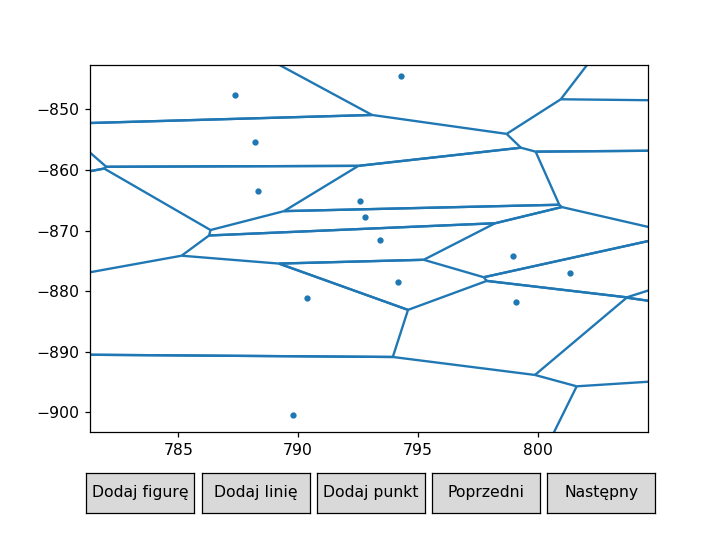

In [189]:
plot1 = Plot( lines = [LinesCollection(result)], points = [PointsCollection(points,marker = ".")] )
plot1.draw()

In [ ]:
times = []
for i in range(200):
    points = [(uniform(-1000, 1000),uniform(-1000, 1000)) for i in range(100*(i+1))]
    r, t = fortune(points)
    times.append(t)
    print(t,i)    

In [ ]:
print(times)